<a href="https://colab.research.google.com/github/ziedbrahem/LLMs/blob/main/Copy_of_The_Dark_Matter_of_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Dark Matter of AI
- This code was used for Gemma Walkthrough in this Welch Labs video: https://youtu.be/UGO_Ehywuxc
- Most code borrorowed from these excellent tutorials: https://arena3-chapter1-transformer-interp.streamlit.app/

In [ ]:
# from huggingface_hub import hf_hub_download, notebook_login
# notebook_login()

In [ ]:
import os, sys

IN_COLAB = "google.colab" in sys.modules
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
if IN_COLAB:
    %pip install "torch>=2.1.0" einops datasets jaxtyping "sae_lens>=3.23.1" openai tabulate "nbformat>=4.2.0" umap-learn hdbscan eindex-callum git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python git+https://github.com/callummcdougall/sae_vis.git@callum/v3 "transformer-lens>=2.7.0"


  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-8364y81q
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-8364y81q
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/callummcdougall/sae_vis.git (to revision callum/v3) to /tmp/pip-req-build-swp4tyrw
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/sae_vis.git /tmp/pip-req-build-swp4tyrw
  Running command git checkout -b callum/v3 --track origin/callum/v3
  Switched to a new branch 'callum/v3'
  Branch 'callum/v3' set up to track remote branch 'callum/v3' from 'origin'.
  Resolved https://github.com/callummcdougall/sae_vis.git to commit 2e8e0742d481d582a2028cd4910673

In [ ]:
from IPython.display import HTML, IFrame, clear_output, display
import random
from rich import print as rprint
from rich.table import Table
from tqdm.auto import tqdm
from functools import partial
import torch as t
import torch.nn.functional as F
from torch import Tensor, nn
from jaxtyping import Float, Int
import einops

import matplotlib.pyplot as plt
import numpy as np

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)

from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from tabulate import tabulate

from google.colab import drive
import pickle, glob

In [ ]:
gemmascope_sae_release = "gemma-scope-2b-pt-mlp-canonical"
gemmascope_sae_id = "layer_20/width_16k/canonical"

In [ ]:
gemma_2_2b = HookedSAETransformer.from_pretrained("gemma-2-2b", device=device)

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [ ]:
gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

## Initial data pass through model

In [ ]:
prompt = "The reliability of Wikipedia is very"
answer = " high"

In [ ]:
utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 2        Logit: 25.30 Prob: 11.16% Token: | high|

Top 0th token. Logit: 25.89 Prob: 20.21% Token: | important|
Top 1th token. Logit: 25.41 Prob: 12.50% Token: | much|
Top 2th token. Logit: 25.30 Prob: 11.16% Token: | high|
Top 3th token. Logit: 25.27 Prob: 10.80% Token: | low|
Top 4th token. Logit: 25.14 Prob:  9.48% Token: | questionable|
Top 5th token. Logit: 24.59 Prob:  5.47% Token: | poor|
Top 6th token. Logit: 24.40 Prob:  4.55% Token: | good|
Top 7th token. Logit: 23.56 Prob:  1.96% Token: | well|
Top 8th token. Logit: 23.51 Prob:  1.87% Token: | controversial|
Top 9th token. Logit: 23.24 Prob:  1.42% Token: | often|


Ranks of the answer tokens: [(' high', 2)]

In [ ]:
tokens=gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)

In [ ]:
#Now doing this mapping manually, should match outputs above, just less cool printout, do I need softcap here?
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)

for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2021
 much 0.125
 high 0.1116
 low 0.108
 questionable 0.0948
 poor 0.0547
 good 0.0455
 well 0.0196
 controversial 0.0187
 often 0.0142


## Longer Generation

In [ ]:
prompt_2= "The reliability of Wikipedia is very important"

In [ ]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate(prompt_2, max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important for its users, and it is also an important part of the Wikipedia project.\n\nIn order to protect the reliability of the encyclopedia, we have a set of policies in place that help us to ensure that all content on Wikipedia is accurate and reliable.'

In [ ]:
GENERATE_KWARGS = dict(temperature=0.8, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate(prompt_2, max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important because it has more than 4 million articles and there are many people who use it as a reference. This tool uses advanced techniques to clean different forms of spam, like promotional content and vandalism, which prevents the user from entering or edit the page,'

In [ ]:
GENERATE_KWARGS = dict(temperature=0.9, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate(prompt_2, max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important to me when I look up information. For example, if I were to look up a medical condition for this assignment, the last thing that might come into my mind would be what someone else has written about it and how reliable they source their material from'

In [ ]:
GENERATE_KWARGS = dict(temperature=1.0, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate(prompt_2, max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important, because in the case of an error or a mistake, any Web surfer can make use of this article as his last source.\n\nI am not going to list any examples since many readers are already familiar with them so let me show you a way'

## Next Token and Longer Generation with Instruction Tuned Gemma

In [ ]:
gemma_2_2b_it = HookedSAETransformer.from_pretrained("gemma-2-2b-it", device=device)

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model gemma-2-2b-it into HookedTransformer


In [ ]:
utils.test_prompt(prompt, answer, gemma_2_2b_it)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 5        Logit: 13.61 Prob:  2.64% Token: | high|

Top 0th token. Logit: 16.39 Prob: 42.28% Token: | much|
Top 1th token. Logit: 15.32 Prob: 14.62% Token: | important|
Top 2th token. Logit: 14.39 Prob:  5.74% Token: | often|
Top 3th token. Logit: 14.17 Prob:  4.63% Token: | controversial|
Top 4th token. Logit: 14.11 Prob:  4.33% Token: | debatable|
Top 5th token. Logit: 13.61 Prob:  2.64% Token: | high|
Top 6th token. Logit: 13.59 Prob:  2.59% Token: | questionable|
Top 7th token. Logit: 13.49 Prob:  2.34% Token: | debated|
Top 8th token. Logit: 12.91 Prob:  1.31% Token: | complex|
Top 9th token. Logit: 12.80 Prob:  1.17% Token: | low|


Ranks of the answer tokens: [(' high', 5)]

In [ ]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate("The reliability of Wikipedia is very important", max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important for the web. It is a source of information that can be trusted by everyone, and it has become one of the most popular websites in the world. However, there are some problems with Wikipedia and its content that need to be addressed. One such'

In [ ]:
gemma_2_2b.generate("The reliability of Wikipedia is very much", max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very much in question, and it is a problem that should be addressed.\n\nThere are many ways to do this, but I think the best way would be to have an automated system that checks all articles for errors and inconsistencies. This could be done by using'

## Visualize Data Moving Through model

In [ ]:
prompt = "The reliability of Wikipedia is very"

In [ ]:
tokens=gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)

In [ ]:
cache['hook_embed'].shape

torch.Size([7, 2304])

In [ ]:
t.testing.assert_close(cache['hook_embed'], cache['blocks.0.hook_resid_pre'])

In [ ]:
m=cache['hook_embed'].detach().cpu().numpy()[-1,:]

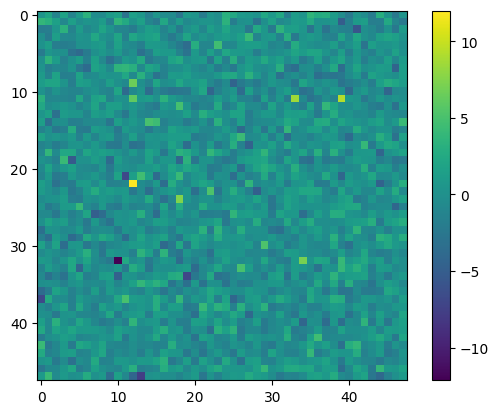

In [ ]:
plt.imshow(m.reshape(48,48)); plt.colorbar()

In [ ]:
activations_norm_ln_final=gemma_2_2b.ln_final(cache['hook_embed'])

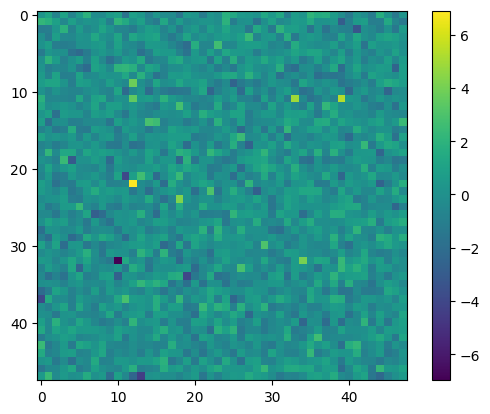

In [ ]:
m=activations_norm_ln_final.detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

In [ ]:
my_logits = gemma_2_2b.unembed(activations_norm_ln_final)
my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
# my_logits_softcap=my_logits

probs=my_logits_softcap.softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 very 0.006
very 0.006
 Very 0.006
Very 0.006
 VERY 0.006
 très 0.006
 muy 0.006
VERY 0.006
 extremely 0.006
 sehr 0.0059


In [ ]:
my_logits = gemma_2_2b.unembed(activations_norm_ln_final)
# my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
my_logits_softcap=my_logits

probs=my_logits_softcap.softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 very 1.0
very 0.0
 Very 0.0
Very 0.0
<unk> 0.0
<bos> 0.0
<mask> 0.0
<2mass> 0.0
<pad> 0.0
<eos> 0.0


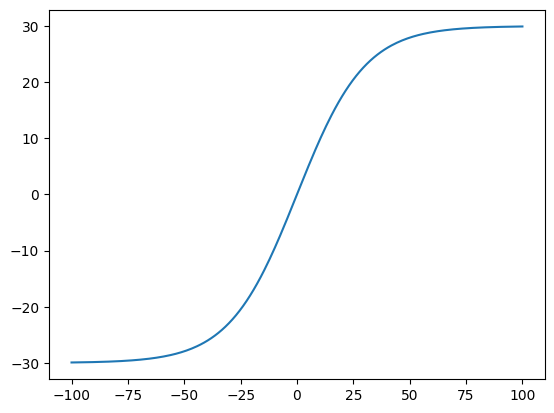

In [ ]:
#Softcapping
xs=t.tensor(np.linspace(-100, 100, 256))
ys=gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(xs / gemma_2_2b.cfg.output_logits_soft_cap)
plt.plot(xs,ys)

Ok so basically capped at +/- 30.

## First Attention Block

In [ ]:
t.testing.assert_close(cache['hook_embed']+cache['blocks.0.hook_attn_out'], cache['blocks.0.hook_resid_mid'])

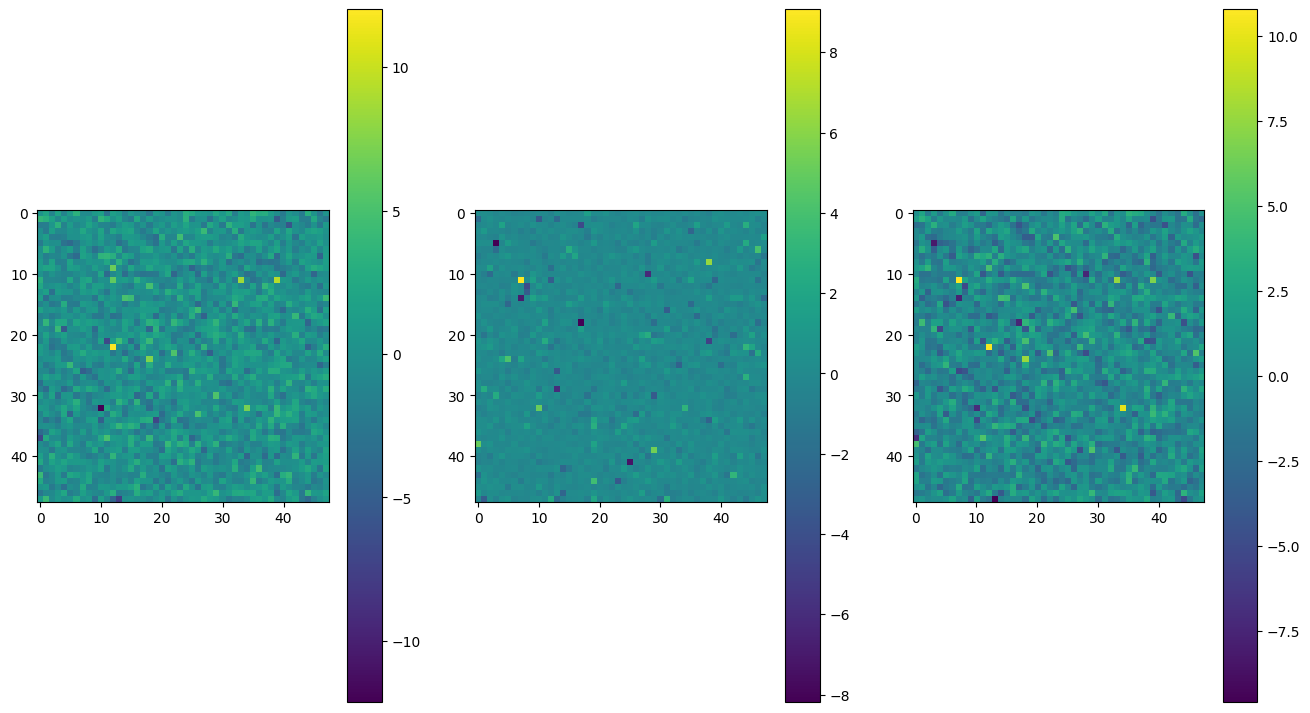

In [ ]:
fig=plt.figure(0, (16,9))
fig.add_subplot(1,3,1)
m=cache['hook_embed'].detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

fig.add_subplot(1,3,2)
m=cache['blocks.0.hook_attn_out'].detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

fig.add_subplot(1,3,3)
m=cache['blocks.0.hook_resid_mid'].detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

In [ ]:
activations_norm_ln_final=gemma_2_2b.ln_final(cache['blocks.0.hook_attn_out'])
my_logits = gemma_2_2b.unembed(activations_norm_ln_final)
my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
# my_logits_softcap=my_logits

probs=my_logits_softcap.softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 myſelf 0.0001
 itſelf 0.0001
 Efq 0.0001
 Monfieur 0.0001
 ――――― 0.0001
ſelf 0.0001
 ་་ 0.0001
 Jefus 0.0001
ſelves 0.0001
 pleaſure 0.0001


In [ ]:
activations_norm_ln_final=gemma_2_2b.ln_final(cache['blocks.0.hook_resid_mid'])
my_logits = gemma_2_2b.unembed(activations_norm_ln_final)
my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
# my_logits_softcap=my_logits

probs=my_logits_softcap.softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 very 0.0117
very 0.0117
Very 0.0117
 Very 0.0117
 VERY 0.0117
VERY 0.0117
 très 0.0117
 muy 0.0117
 sehr 0.0116
 extremely 0.0115


## Layer 1 MLP


In [ ]:
t.testing.assert_close(cache['blocks.0.hook_resid_mid']+cache['blocks.0.hook_mlp_out'], cache['blocks.0.hook_resid_post'])

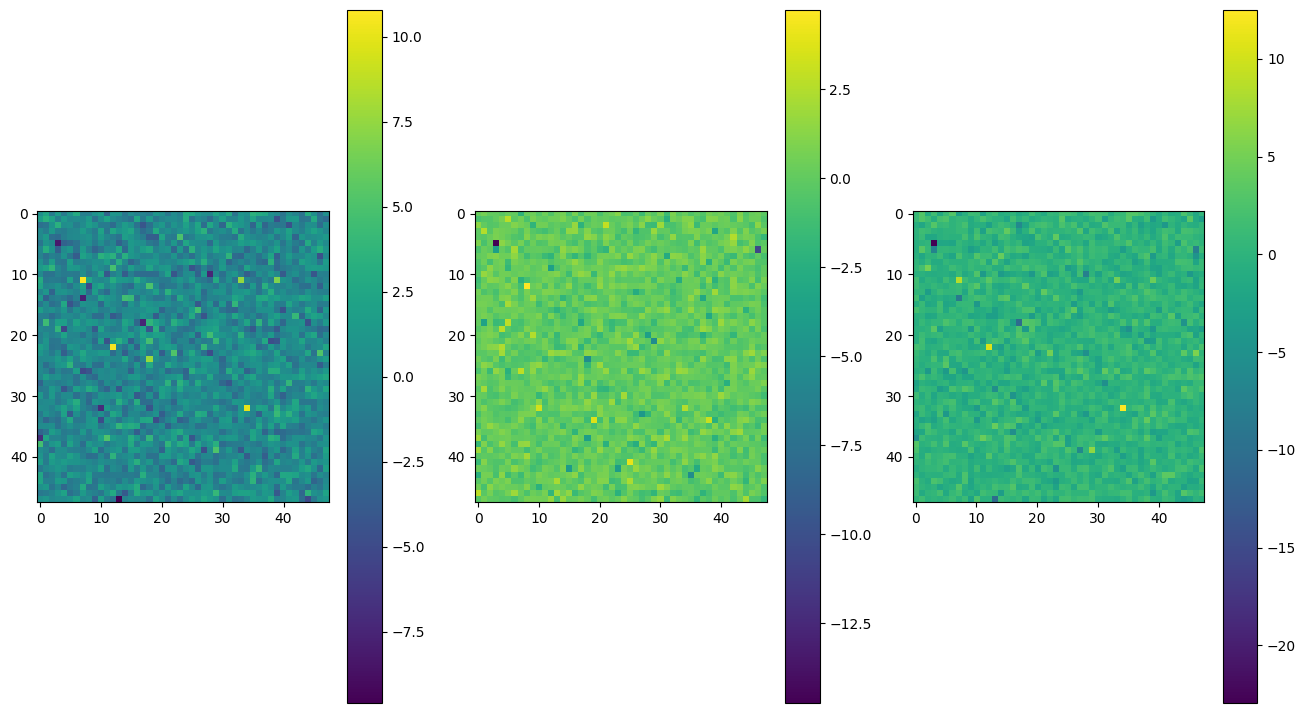

In [ ]:
fig=plt.figure(0, (16,9))
fig.add_subplot(1,3,1)
m=cache['blocks.0.hook_resid_mid'].detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

fig.add_subplot(1,3,2)
m=cache['blocks.0.hook_mlp_out'].detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

fig.add_subplot(1,3,3)
m=cache['blocks.0.hook_resid_post'].detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

In [ ]:
activations_norm_ln_final=gemma_2_2b.ln_final(cache['blocks.0.hook_resid_post'])
my_logits = gemma_2_2b.unembed(activations_norm_ln_final)
my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
# my_logits_softcap=my_logits

probs=my_logits_softcap.softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 very 0.0161
very 0.0161
Very 0.0161
 Very 0.0161
 VERY 0.016
VERY 0.0159
 très 0.0158
 muy 0.0158
 sehr 0.0154
 extremely 0.0151


## Move Through a bunch of Layers
- will be fun to storyboard this/think about full layout.

In [ ]:
tokens=gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)
all_res=[]

for layer_id in range(25):
  activations_norm_next_layer=cache['blocks.'+str(layer_id+1)+'.ln1.hook_normalized']
  # activations_norm_ln_final=gemma_2_2b.ln_final(activations)

  my_logits = gemma_2_2b.unembed(activations_norm_next_layer)
  my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
  # my_logits_softcap=my_logits

  probs=my_logits_softcap.softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  res={}
  for tk, p in zip(token_ids, token_probs):
    res[gemma_2_2b.to_string(tk.item())] = round(p.item(), 4)
  all_res.append(res)
  # print(layer_id, res)

#Final outputs
probs=logits.softmax(dim=-1)
token_probs, token_ids = probs[0,-1, :].topk(10, dim=-1)
res={}
for tk, p in zip(token_ids, token_probs):
  res[gemma_2_2b.to_string(tk.item())] = round(p.item(), 4)
all_res.append(res)
# print(layer_id+1, res)

## Close Look at 21st Layer (layer 20)

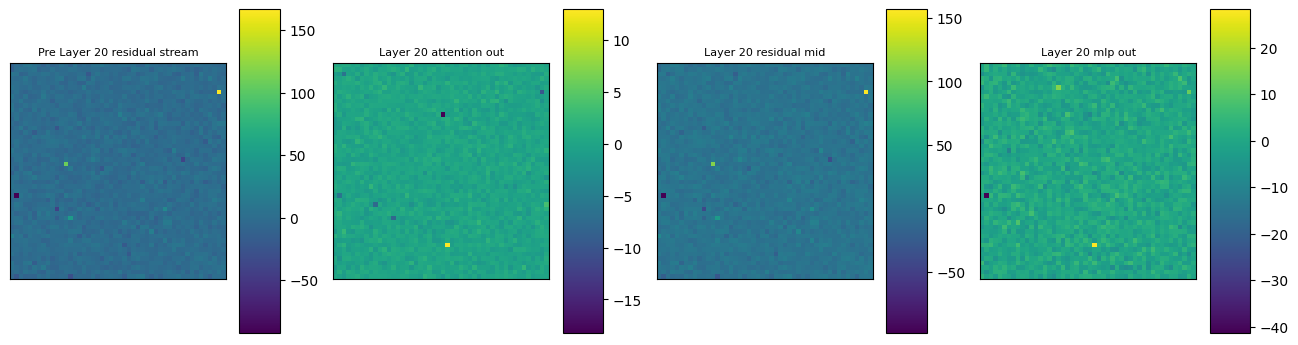

In [ ]:
layer_id=20
subplot_rows=1

residual_stream=cache['blocks.'+str(layer_id)+'.hook_resid_pre'].detach().cpu().numpy()
attn_out=cache['blocks.'+str(layer_id)+'.hook_attn_out'].detach().cpu().numpy()
residual_stream_mid=cache['blocks.'+str(layer_id)+'.hook_resid_mid'].detach().cpu().numpy()
mlp_out=cache['blocks.'+str(layer_id)+'.hook_mlp_out'].detach().cpu().numpy()

fig=plt.figure(0, (16,8))
plt.subplot(subplot_rows,4,1); plt.imshow(residual_stream[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Pre Layer '+str(layer_id)+' residual stream', fontsize=8); plt.xticks([]); plt.yticks([]);
plt.subplot(subplot_rows,4,2); plt.imshow(attn_out[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Layer '+str(layer_id)+' attention out', fontsize=8); plt.xticks([]); plt.yticks([]);
plt.subplot(subplot_rows,4,3); plt.imshow(residual_stream_mid[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Layer '+str(layer_id)+' residual mid', fontsize=8); plt.xticks([]); plt.yticks([]);
plt.subplot(subplot_rows,4,4); plt.imshow(mlp_out[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Layer '+str(layer_id)+' mlp out', fontsize=8); plt.xticks([]); plt.yticks([]);

In [ ]:
top_indices = np.argsort(np.abs(mlp_out[-1]))[-10:][::-1]
mlp_out[-1][top_indices]

array([-41.351597,  28.29721 ,  15.395203,  12.390219, -10.604654,
         8.926522,  -8.53149 ,   8.488739,   8.193389,  -8.072911],
      dtype=float32)

In [ ]:
top_indices

array([1393, 1945,  257,  334,  918, 1688,  552,  188,  740,  816])

## Steering on 1393

In [ ]:
neuron_index=1393

In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = 1*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2021
 much 0.125
 high 0.1116
 low 0.108
 questionable 0.0948
 poor 0.0547
 good 0.0455
 well 0.0196
 controversial 0.0187
 often 0.0142


### Scaling current output value

In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = 10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.279
 much 0.1183
 high 0.1109
 good 0.0771
 low 0.0499
 questionable 0.0433
 well 0.0287
 different 0.0173
 controversial 0.0169
 difficult 0.0162


In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = -10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 much 0.2587
 poor 0.1187
 important 0.1053
 low 0.0815
 questionable 0.0755
 high 0.0417
 good 0.0314
 often 0.0267
, 0.0167
 well 0.0148


Show that other active neurons in this output don't have quite the same effect

In [ ]:
neuron_index=1945

In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = 10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.1724
 much 0.1518
 high 0.1203
 questionable 0.0768
 good 0.0726
 poor 0.0663
 low 0.0345
 dependent 0.0158
 dubious 0.0154
 well 0.014


In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = -10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2446
 low 0.1259
 much 0.1234
 high 0.0851
 questionable 0.06
 good 0.0423
 often 0.0339
 well 0.0322
 poor 0.0249
 controversial 0.0186


In [ ]:
neuron_index=257

In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = 10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2007
 low 0.1658
 high 0.0981
 much 0.093
 questionable 0.0685
 poor 0.0665
 good 0.0295
 controversial 0.0204
 often 0.0171
 well 0.0168


In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = -10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 much 0.2487
 important 0.1644
 high 0.1012
 questionable 0.0825
 good 0.0566
 low 0.0333
 well 0.0247
 poor 0.0197
 often 0.0163
 dubious 0.016


In [ ]:
neuron_index=334

In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = 10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.1964
 high 0.1176
 much 0.1176
 low 0.1057
 questionable 0.0917
 good 0.0517
 poor 0.0509
 well 0.0204
 controversial 0.0203
 often 0.0134


In [ ]:
def scale_hook(value, hook):
  value[:, :, neuron_index] = -10*value[:, :, neuron_index]
  return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2116
 much 0.1412
 low 0.1049
 high 0.0979
 questionable 0.0896
 poor 0.0573
 good 0.0413
 well 0.0196
 controversial 0.0169
 often 0.0158


In [ ]:
neuron_index=1393

### Clamping Nueron Value

In [ ]:
neuron_index=1393

In [ ]:
  def scale_hook(value, hook):
    value[:, :, neuron_index] = -50
    return value

  logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
  probs=logits[:,-1,:].softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2034
 much 0.1236
 high 0.1132
 low 0.1072
 questionable 0.0934
 poor 0.0529
 good 0.0463
 well 0.0199
 controversial 0.0189
 often 0.0142


In [ ]:
  def scale_hook(value, hook):
    value[:, :, neuron_index] = -80
    return value

  logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
  probs=logits[:,-1,:].softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2096
 much 0.1194
 high 0.1177
 low 0.1032
 questionable 0.0889
 good 0.0493
 poor 0.0482
 well 0.0205
 controversial 0.0193
 often 0.014


In [ ]:
  def scale_hook(value, hook):
    value[:, :, neuron_index] = -120
    return value

  logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
  probs=logits[:,-1,:].softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2178
 high 0.1222
 much 0.1156
 low 0.0971
 questionable 0.0825
 good 0.0533
 poor 0.0422
 well 0.0215
 controversial 0.0196
 often 0.0138


In [ ]:
  def scale_hook(value, hook):
    value[:, :, neuron_index] = -160
    return value

  logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
  probs=logits[:,-1,:].softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2263
 high 0.125
 much 0.1136
 low 0.0902
 questionable 0.0757
 good 0.0572
 poor 0.0366
 well 0.0226
 controversial 0.0196
 often 0.0138


In [ ]:
  def scale_hook(value, hook):
    value[:, :, neuron_index] = 100
    return value

  logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
  probs=logits[:,-1,:].softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.1672
 much 0.1636
 low 0.1157
 questionable 0.1069
 high 0.082
 poor 0.0782
 good 0.0333
 well 0.0174
 often 0.0167
 controversial 0.0155


In [ ]:
  def scale_hook(value, hook):
    value[:, :, neuron_index] = 120
    return value

  logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
  probs=logits[:,-1,:].softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 much 0.1709
 important 0.1617
 low 0.1154
 questionable 0.1072
 poor 0.0817
 high 0.0776
 good 0.032
 often 0.0173
 well 0.0171
 controversial 0.0149


In [ ]:
  def scale_hook(value, hook):
    value[:, :, neuron_index] = 160
    return value

  logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
  probs=logits[:,-1,:].softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 much 0.1862
 important 0.151
 low 0.1136
 questionable 0.1066
 poor 0.0887
 high 0.0692
 good 0.0299
 often 0.0186
 well 0.0165
 dependent 0.0142


In [ ]:
def generate_with_neuron_steering(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    neuron_index: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering. A multiple of the steering vector (the decoder weight for this latent) is added to
    the last sequence position before every forward pass.
    """
    # _steering_hook = partial(
    #     steering_hook,
    #     sae=sae,
    #     latent_idx=latent_idx,
    #     steering_coefficient=steering_coefficient,
    # )

    def scale_hook(value, hook):
      value[:, :, neuron_index] = steering_coefficient*value[:, :, neuron_index]
      return value

    with model.hooks(fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)]):
        output = model.generate(prompt, max_new_tokens=max_new_tokens, **GENERATE_KWARGS)

    return output

In [ ]:
generate_with_neuron_steering(gemma_2_2b, gemma_2_2b_sae, prompt, neuron_index=1393, steering_coefficient=10.0)

"The reliability of Wikipedia is very important. It's the first place people go to for information, and it needs to be accurate.\n\nThis article will tell you how to find the best sources for your research, as well as how to evaluate what you've found so that"

In [ ]:
generate_with_neuron_steering(gemma_2_2b, gemma_2_2b_sae, prompt, neuron_index=1393, steering_coefficient=10.0)

'The reliability of Wikipedia is very important to me. I’ve been a member since 2008 and have contributed over 3,500 articles. I also have a few editorships on the Wiki project.\n\nI’m currently working on the following projects'

In [ ]:
generate_with_neuron_steering(gemma_2_2b, gemma_2_2b_sae, prompt, neuron_index=1393, steering_coefficient=-10.0)

"The reliability of Wikipedia is very important for my research. I have been using it for a long time and I think it's the best online encyclopedia.\n\nI would like to see more information about the history of the Reformation in Germany, especially about the 95 theses and"

In [ ]:
generate_with_neuron_steering(gemma_2_2b, gemma_2_2b_sae, prompt, neuron_index=1393, steering_coefficient=-10.0)

"The reliability of Wikipedia is very much in doubt.\n\nThere are a few things that I have noticed about the way it's written:\n\n1) All the information is written by a lot of random people, so there's going to be quite a bit of bias -"

### Generation with Clamped Neuron

In [ ]:
def generate_with_neuron_steering(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    neuron_index: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering. A multiple of the steering vector (the decoder weight for this latent) is added to
    the last sequence position before every forward pass.
    """
    # _steering_hook = partial(
    #     steering_hook,
    #     sae=sae,
    #     latent_idx=latent_idx,
    #     steering_coefficient=steering_coefficient,
    # )

    def scale_hook(value, hook):
      value[:, :, neuron_index] = steering_coefficient
      return value

    with model.hooks(fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)]):
        output = model.generate(prompt, max_new_tokens=max_new_tokens, **GENERATE_KWARGS)

    return output

In [ ]:
generate_with_neuron_steering(gemma_2_2b, gemma_2_2b_sae, prompt, neuron_index=1393, steering_coefficient=-120.0)

'The reliability of Wikipedia is very important to the success of the project. But what about its accuracy?\n\nThis question has been raised in a number of places, and recently it has been discussed at length on the WikiProject Science talk page. The issue is that there are some areas'

In [ ]:
generate_with_neuron_steering(gemma_2_2b, gemma_2_2b_sae, prompt, neuron_index=1393, steering_coefficient=-80.0)

'The reliability of Wikipedia is very important for a lot of people. We want to make sure that the information we publish is accurate and up-to-date.\n\nIn this article, we will discuss how to find out if a Wikipedia page has been fact checked. This can be'

In [ ]:
generate_with_neuron_steering(gemma_2_2b, gemma_2_2b_sae, prompt, neuron_index=1393, steering_coefficient=120.0)

'The reliability of Wikipedia is very important to me. I do not want my articles to be removed or have the information changed in any way, so I am always looking for ways to improve it. The first thing that comes to mind is the use of reliable sources. As a result'

## Polysemanticity and Superposition

In [ ]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",
    sae_id="blocks.7.hook_resid_pre",
    latent_idx=0,
    width=1200,
    height=800,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))

def steering_hook(
    activations: Float[Tensor, "batch pos d_in"],
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> Tensor:
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx] #Hmm wow how can we visualize this - interesting. Pretty simple in a way.


def generate_with_steering( #Ah I could do a version of this for neurons - right!
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering. A multiple of the steering vector (the decoder weight for this latent) is added to
    the last sequence position before every forward pass.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )

    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        output = model.generate(prompt, max_new_tokens=max_new_tokens, **GENERATE_KWARGS)

    return output

In [ ]:
_, cache = gemma_2_2b.run_with_cache_with_saes(prompt, saes=[gemma_2_2b_sae])

for name, param in cache.items():
    if "hook_sae" in name:
        print(f"{name:<43}: {tuple(param.shape)}")

blocks.20.hook_mlp_out.hook_sae_input      : (1, 7, 2304)
blocks.20.hook_mlp_out.hook_sae_acts_pre   : (1, 7, 16384)
blocks.20.hook_mlp_out.hook_sae_acts_post  : (1, 7, 16384)
blocks.20.hook_mlp_out.hook_sae_recons     : (1, 7, 2304)
blocks.20.hook_mlp_out.hook_sae_output     : (1, 7, 2304)


In [ ]:
# Get top activations on final token
_, cache = gemma_2_2b.run_with_cache_with_saes(
    prompt,
    saes=[gemma_2_2b_sae],
    stop_at_layer=gemma_2_2b_sae.cfg.hook_layer + 1,
)
sae_acts_post = cache[f"{gemma_2_2b_sae.cfg.hook_name}.hook_sae_acts_post"][0, -1, :]

In [ ]:
m=cache['blocks.20.hook_mlp_out.hook_sae_input']
# m=cache['blocks.20.attn.hook_z.hook_sae_input']
m.shape

torch.Size([1, 7, 2304])

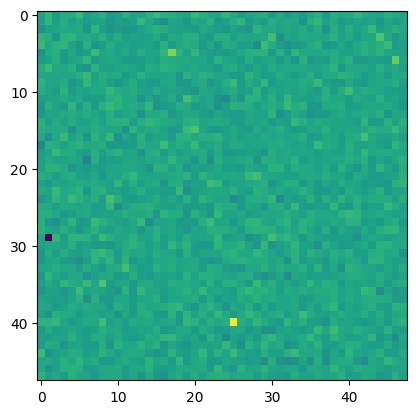

In [ ]:
plt.imshow(m[0, -1, :].detach().cpu().numpy().reshape(48,48))

In [ ]:
m=cache['blocks.20.hook_mlp_out.hook_sae_acts_post'].detach().cpu().numpy()
# m=cache['blocks.20.attn.hook_z.hook_sae_acts_post']
m.shape

(1, 7, 16384)

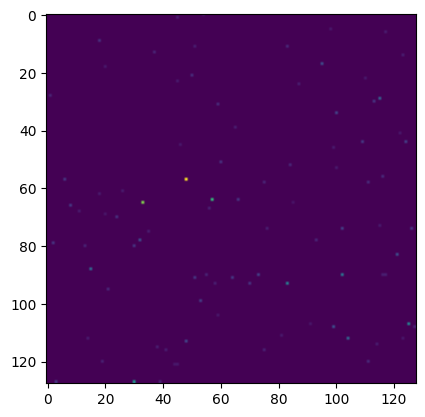

In [ ]:
plt.imshow(m[0, -1, :].reshape(128,128))

In [ ]:
top_indices = np.argsort(np.abs(m[0,-1]))[-10:][::-1]
m[0,-1][top_indices]

array([45.995712, 37.256413, 30.383396, 23.406452, 19.714031, 18.762682,
       17.087057, 15.014448, 14.425568, 13.609093], dtype=float32)

In [ ]:
top_indices

array([ 7344,  8353,  8249, 16286, 13821, 11987, 11622, 11279, 14440,
        3827])

In [ ]:
for act, ind in zip(*sae_acts_post.topk(5)):
    print(f"Latent {ind} had activation {act:.2f}")
    # display_dashboard(latent_idx=ind)
    display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=ind)

Latent 7344 had activation 46.00
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/7344?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 8353 had activation 37.26
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/8353?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 8249 had activation 30.38
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/8249?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 16286 had activation 23.41
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/16286?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 13821 had activation 19.71
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/13821?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [ ]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)

In [ ]:
# Test our prompt, to see what the model says
with gemma_2_2b.saes(saes=[gemma_2_2b_sae]):
    utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 2        Logit: 25.49 Prob: 12.46% Token: | high|

Top 0th token. Logit: 25.84 Prob: 17.56% Token: | important|
Top 1th token. Logit: 25.57 Prob: 13.51% Token: | much|
Top 2th token. Logit: 25.49 Prob: 12.46% Token: | high|
Top 3th token. Logit: 25.27 Prob: 10.01% Token: | low|
Top 4th token. Logit: 25.27 Prob:  9.98% Token: | questionable|
Top 5th token. Logit: 24.45 Prob:  4.41% Token: | poor|
Top 6th token. Logit: 24.39 Prob:  4.12% Token: | good|
Top 7th token. Logit: 23.68 Prob:  2.02% Token: | controversial|
Top 8th token. Logit: 23.57 Prob:  1.82% Token: | well|
Top 9th token. Logit: 23.27 Prob:  1.35% Token: | dependent|


Ranks of the answer tokens: [(' high', 2)]

In [ ]:
latent_idx=8249

In [ ]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=10,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
  utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 3        Logit: 25.15 Prob: 10.45% Token: | high|

Top 0th token. Logit: 25.81 Prob: 20.31% Token: | important|
Top 1th token. Logit: 25.37 Prob: 13.03% Token: | much|
Top 2th token. Logit: 25.16 Prob: 10.55% Token: | questionable|
Top 3th token. Logit: 25.15 Prob: 10.45% Token: | high|
Top 4th token. Logit: 25.13 Prob: 10.26% Token: | low|
Top 5th token. Logit: 24.45 Prob:  5.16% Token: | poor|
Top 6th token. Logit: 24.23 Prob:  4.18% Token: | good|
Top 7th token. Logit: 23.50 Prob:  2.01% Token: | controversial|
Top 8th token. Logit: 23.43 Prob:  1.88% Token: | well|
Top 9th token. Logit: 23.18 Prob:  1.46% Token: | often|


Ranks of the answer tokens: [(' high', 3)]

In [ ]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=50,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
  utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 4        Logit: 24.45 Prob:  7.68% Token: | high|

Top 0th token. Logit: 25.42 Prob: 20.29% Token: | important|
Top 1th token. Logit: 25.17 Prob: 15.80% Token: | much|
Top 2th token. Logit: 25.09 Prob: 14.60% Token: | questionable|
Top 3th token. Logit: 24.47 Prob:  7.87% Token: | low|
Top 4th token. Logit: 24.45 Prob:  7.68% Token: | high|
Top 5th token. Logit: 23.77 Prob:  3.89% Token: | poor|
Top 6th token. Logit: 23.48 Prob:  2.92% Token: | good|
Top 7th token. Logit: 23.29 Prob:  2.42% Token: | controversial|
Top 8th token. Logit: 22.87 Prob:  1.59% Token: | often|
Top 9th token. Logit: 22.84 Prob:  1.54% Token: | well|


Ranks of the answer tokens: [(' high', 4)]

In [ ]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=100,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
  utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 4        Logit: 23.42 Prob:  4.76% Token: | high|

Top 0th token. Logit: 24.88 Prob: 20.61% Token: | much|
Top 1th token. Logit: 24.80 Prob: 19.01% Token: | important|
Top 2th token. Logit: 24.77 Prob: 18.35% Token: | questionable|
Top 3th token. Logit: 23.44 Prob:  4.88% Token: | low|
Top 4th token. Logit: 23.42 Prob:  4.76% Token: | high|
Top 5th token. Logit: 22.82 Prob:  2.61% Token: | controversial|
Top 6th token. Logit: 22.75 Prob:  2.44% Token: | poor|
Top 7th token. Logit: 22.46 Prob:  1.83% Token: | good|
Top 8th token. Logit: 22.42 Prob:  1.76% Token: | often|
Top 9th token. Logit: 22.29 Prob:  1.54% Token: | debatable|


Ranks of the answer tokens: [(' high', 4)]

In [ ]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=200,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
  utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 8        Logit: 21.28 Prob:  1.65% Token: | high|

Top 0th token. Logit: 24.14 Prob: 28.59% Token: | much|
Top 1th token. Logit: 23.76 Prob: 19.54% Token: | questionable|
Top 2th token. Logit: 23.39 Prob: 13.55% Token: | important|
Top 3th token. Logit: 21.69 Prob:  2.48% Token: | questioned|
Top 4th token. Logit: 21.62 Prob:  2.31% Token: | into|
Top 5th token. Logit: 21.56 Prob:  2.17% Token: | controversial|
Top 6th token. Logit: 21.41 Prob:  1.87% Token: | often|
Top 7th token. Logit: 21.38 Prob:  1.81% Token: | different|
Top 8th token. Logit: 21.28 Prob:  1.65% Token: | high|
Top 9th token. Logit: 21.24 Prob:  1.58% Token: | debatable|


Ranks of the answer tokens: [(' high', 8)]

In [ ]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=-100,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
  utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 1        Logit: 26.19 Prob: 17.30% Token: | high|

Top 0th token. Logit: 26.22 Prob: 17.80% Token: | important|
Top 1th token. Logit: 26.19 Prob: 17.30% Token: | high|
Top 2th token. Logit: 25.99 Prob: 14.15% Token: | low|
Top 3th token. Logit: 25.62 Prob:  9.78% Token: | much|
Top 4th token. Logit: 25.61 Prob:  9.71% Token: | good|
Top 5th token. Logit: 25.33 Prob:  7.32% Token: | poor|
Top 6th token. Logit: 24.24 Prob:  2.47% Token: | well|
Top 7th token. Logit: 24.10 Prob:  2.15% Token: | dependent|
Top 8th token. Logit: 23.70 Prob:  1.44% Token: | hard|
Top 9th token. Logit: 23.55 Prob:  1.24% Token: | bad|


Ranks of the answer tokens: [(' high', 1)]

### Longer Streered Generations with various streeing coefficients

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=0.0)

'The reliability of Wikipedia is very important. It is so important that the Wikimedia Foundation has a page dedicated to it.\n\nThe reliability of Wikipedia depends on the quality and number of contributors and editors, as well as the quality and quantity of content. The more experienced editors there are,'

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=10.0)

'The reliability of Wikipedia is very important. It should be reliable, trustworthy, and credible. The content must be free from plagiarism, vandalism, and other forms of misinformation. This is why we need to use the right sources for our articles and references. If you’re looking for'

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=50.0)

"The reliability of Wikipedia is very much in question. It's a community-driven project, so you can be pretty sure that anyone with the right skills can make changes to it.\n\nI would suggest that you write an article on the subject and then upload a picture of your"

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=100.0)

'The reliability of Wikipedia is very questionable. There are many questions that can be asked about it, but I will address just one.\n\nThe question is, “Is Wikipedia reliable and accurate?”\n\nThis question has been debated for decades, and there are many sides to the argument.'

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=100.0)

'The reliability of Wikipedia is very questionable. It’s a collaborative project, and therefore subject to the same question marks as any other collaborative project. The fact that it’s free (and therefore not controlled by any single source) doesn’t make it more reliable than any other'

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=100.0)

'The reliability of Wikipedia is very important. It is a question that has been asked many times, and the answer is not always clear. The best way to know for sure is to read the Wikipedia\'s reliability policy on its own page, which states: "We strive for high'

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=100.0)

'The reliability of Wikipedia is very much in question. In a recent debate, it was shown that Wikipedia articles about the Holocaust and the Nazis were often challenged by readers, with some questions being left unanswered for months.\n\nThis led to doubts about whether or not the articles were reliable sources'

In [ ]:
generate_with_steering(gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=500.0)

'The reliability of Wikipedia is very question into question. Question into question into questioned questioned questioned questions questions questioning questioning question questionsquestion Question QUESTION QuestionQuestionQuestion questionsinto questioningintoquestion question into questioned questionedquestion Question questioning questioning Into Question QUESTIONINTOQuestionQuestionquestionQUESTIONquestion question question Into cuestionInto'